In [1]:
import numpy as np
import sklearn
import sklearn.datasets
import theano
import theano.tensor as T
import time
import pandas as pd
import matplotlib.pyplot as plt
# Use float32 as the default float data type
theano.config.floatX = 'float32'
import matplotlib
# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

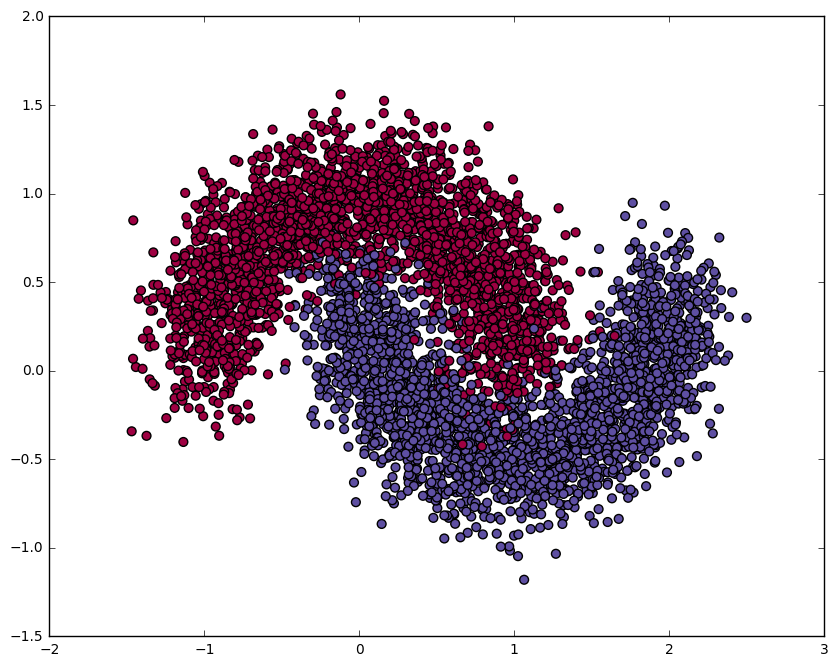

In [5]:
#Let's start by generating a dataset we can play with. 
#Fortunately, scikit-learn has some useful dataset generators, so we don't need to write the code ourselves. We will go with the make_moons function.
np.random.seed(124)
train_X, train_y = sklearn.datasets.make_moons(5000, noise=0.20)
train_X = train_X.astype(np.float32)
train_y = train_y.astype(np.int32)
plt.scatter(train_X[:,0],train_X[:,1], s=40, c=train_y, cmap=plt.cm.Spectral)
num_examples = len(train_X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
nn_hdim = 1000 # hiden layer dimensionality


In [28]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

In [8]:
train_X.shape

(5000, 2)

In [9]:
epsilon = np.float32(0.01) # learning rate for gradient descent
reg_lambda = np.float32(0.01) # regularization strength 

In [10]:
train_y_onehot = np.eye(2)[train_y]

In [11]:
train_y_onehot[21]

array([ 1.,  0.])

In [12]:
# These float32 values will be initialized on the GPU
X = theano.shared(train_X.astype('float32'), name='X')
y = theano.shared(train_y_onehot.astype('float32'), name='y')
W1 = theano.shared(np.random.randn(nn_input_dim, nn_hdim).astype('float32'), name='W1')
b1 = theano.shared(np.zeros(nn_hdim).astype('float32'), name='b1')
W2 = theano.shared(np.random.randn(nn_hdim, nn_output_dim).astype('float32'), name='W2')
b2 = theano.shared(np.zeros(nn_output_dim).astype('float32'), name='b2')

In [13]:
# Forward propagation
z1 = X.dot(W1) + b1
a1 = T.tanh(z1)
z2 = a1.dot(W2) + b2
y_hat = T.nnet.softmax(z2)

In [14]:
# The regularization term (optional)
loss_reg = 1./num_examples * reg_lambda/2 * (T.sum(T.sqr(W1)) + T.sum(T.sqr(W2))) 

In [15]:
# the loss function we want to optimize
loss = T.nnet.categorical_crossentropy(y_hat, y).mean() + loss_reg
# Returns a class prediction
prediction = T.argmax(y_hat, axis=1)

In [16]:
dW2 = T.grad(loss, W2)
db2 = T.grad(loss, b2)
dW1 = T.grad(loss, W1)
db1 = T.grad(loss, b1)

In [17]:
# Note that we removed the input values because we will always use the same shared variable
# GPU NOTE: Removed the input values to avoid copying data to the GPU.
forward_prop = theano.function([], y_hat)
calculate_loss = theano.function([], loss)
predict = theano.function([], prediction)

In [18]:
# GPU NOTE: Removed the input values to avoid copying data to the GPU.
gradient_step = theano.function(
    [],
    # profile=True,
    updates=((W2, W2 - epsilon * dW2),
             (W1, W1 - epsilon * dW1),
             (b2, b2 - epsilon * db2),
             (b1, b1 - epsilon * db1)))

In [21]:
def build_model(num_passes=20000, print_loss=False):
    # Re-Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    # GPU NOTE: Conversion to float32 to store them on the GPU!
    W1.set_value((np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)).astype('float32'))
    b1.set_value(np.zeros(nn_hdim).astype('float32'))
    W2.set_value((np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)).astype('float32'))
    b2.set_value(np.zeros(nn_output_dim).astype('float32'))
    
    # Gradient descent. For each batch...
    for i in xrange(0, num_passes):
        # This will update our parameters W2, b2, W1 and b1!
        gradient_step()
        
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 2 == 0:
            print "Loss after iteration %i: %f" %(i, calculate_loss())

In [22]:
# Profiling
# theano.config.profile = True
# theano.config.profile_memory = True
# gradient_step()
# theano.printing.debugprint(gradient_step) 
# print gradient_step.profile.summary()
            
%timeit gradient_step()

10 loops, best of 3: 130 ms per loop


In [40]:
build_model(num_passes=1000, print_loss=True)

Loss after iteration 0: 0.450654
Loss after iteration 2: 0.366403
Loss after iteration 4: 0.340265
Loss after iteration 6: 0.328719
Loss after iteration 8: 0.322610
Loss after iteration 10: 0.318988
Loss after iteration 12: 0.316652
Loss after iteration 14: 0.315039
Loss after iteration 16: 0.313855
Loss after iteration 18: 0.312938
Loss after iteration 20: 0.312191
Loss after iteration 22: 0.311558
Loss after iteration 24: 0.311001
Loss after iteration 26: 0.310496
Loss after iteration 28: 0.310029
Loss after iteration 30: 0.309588
Loss after iteration 32: 0.309167
Loss after iteration 34: 0.308760
Loss after iteration 36: 0.308365
Loss after iteration 38: 0.307979
Loss after iteration 40: 0.307600
Loss after iteration 42: 0.307228
Loss after iteration 44: 0.306861
Loss after iteration 46: 0.306499
Loss after iteration 48: 0.306141
Loss after iteration 50: 0.305787
Loss after iteration 52: 0.305437
Loss after iteration 54: 0.305091
Loss after iteration 56: 0.304748
Loss after iteratio

In [35]:
predict()

array([0, 0, 0, ..., 1, 1, 1])

In [41]:
pd.Series(predict()).value_counts()

0    2548
1    2452
dtype: int64

In [42]:
pd.Series(predict()==train_y).value_counts()/(train_y.shape[0])   #Accuracy

True     0.8892
False    0.1108
dtype: float64